# Configurações

Imports de Pacotes

In [1]:
from IPython.display import display, Javascript
from IPython.display import Image
from google.colab.output import eval_js
from base64 import b64decode

Funções úteis

In [2]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Informações do cliente

In [3]:
#@title Preencha aqui com as informações do cliente requisitante

#@markdown Informe todos os campos a seguir:
nome = "Vitor" #@param {type:"string"}

renda = 6000.00 #@param {type:"number"}
idade = 26 #@param {type:"slider", min:18, max:100, step:1}
etnia = "Etnia01"  #@param ["Selecionar etnia", "Etnia01", "Etnia02"]
genero = "Masculino" #@param ["Masculino", "Feminino"]
casa_propria = "Sim" #@param ["Selecionar", "Sim", "Não"]
outras_rendas = "Não" #@param ["Selecionar", "Sim", "Não"]
estado_civil = "Estado01" #@param ["Selecionar", "Estado01", "Estado02"]
escolaridade = 3 #@param {type:"slider", min:0, max:3, step:1}

#@markdown ---


<IPython.core.display.Javascript object>

Saved to photo.jpg


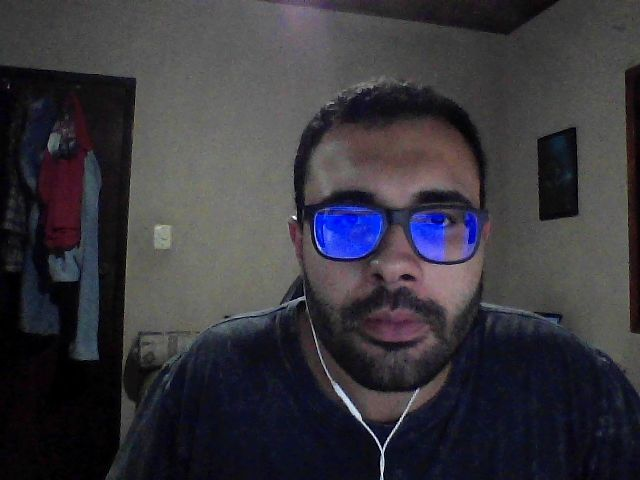

In [4]:
#@title Tire uma foto do cliente requerente (ou tire uma foto sua mesmo)

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Análise de crédito

1. Verifique se na imagem possui uma pessoa, utilizando a API "default" da IBM; Se não possuir, informar mensagem e não conceder o empréstimo.


2.  Verifique se a imagem apresenta conteúdo explícito , utilizando a API "explicit"da IBM; Se possuir, informar mensagem e não conceder o empréstimo.  


3. Verificar o gênero e a idade da pessoa utilizando a API de reconhecimento facial da Microsoft Azure; Se não for o mesmo gênero ou se a idade diferir em 5 anos (para mais ou para menos), informar mensagem e não conceder o empréstimo.


4. Exibir a imagem novamente no notebook com os pontos "fiduciais" da face da pessoa, obtidos pela API da Azure. (em uma aplicação corporativa, estes pontos ficam gravados para futuras autenticações)


5. Chamar a API de Machine Learning em um contêiner feito em Docker e que esteja rodando em uma máquina virtual no Google Cloud. Esta API deve usar os dados informados neste notebook e **automaticamente** vetar ou conceder o empréstimo.


ATENÇÃO PARA O BULLET 5: É necessário chamar tanto um modelo que possua a variável ETNIA quanto um modelo que não possui esta variável, assim como fizemos em aula!!!


6. Gravar um vídeo "operando" o notebook e simulando a avaliação com concessão ou reprovação do crédito.


7. Submeter o Notebook e o vídeo da plataforma da FIAP, se o vídeo ficar muito grande, submeter ao Youtube (pode ser privado) e anexar o Link.

---  
(Dica: Você pode usar este vídeo para divulgar seu trabalho como Engenheiro de ML)


## Utilizando Google Drive

Utilizaremos o Google Drive para armazenar as imagens, assim sera utilizado o comando abaixo para montar seu drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Criando o caminho para as bases de dados e chaves JSON.

In [6]:
data_path = '/content/drive/MyDrive/MBA/Plataformas Cognitivas/Trabalho/data/'
key_path = '/content/drive/MyDrive/MBA/Plataformas Cognitivas/Trabalho/keys/modelosinteligenciaartificial-3594e5388fb6.json'

Devidoa API da IBM não estar mais disponivel será utilizado a API da Google **"CLOUD VISION"**

## CLOUD VISION

In [7]:
!pip install google-cloud-vision

Inserindo credenciais

In [8]:
import os, io

In [9]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

Inicia o **CLOUD VISION**

In [10]:
from google.cloud import vision
client = vision.ImageAnnotatorClient()

Função para verificar se na imagem existe uma pessoa ou não.

In [11]:
def person(path):
  with io.open(path, 'rb') as image_file:
    content = image_file.read()

  image = vision.Image(content=content)

  response = client.face_detection(image=image)
  faces = response.face_annotations

  if faces == []:
    pessoa = False

  else:
    pessoa = True

  return pessoa

Função para verificar se na imagem contém conteudo explicito.

In [12]:
def detect_safe_search(path):
    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.safe_search_detection(image=image)
    safe = response.safe_search_annotation

    likelihood_name = ('UNKNOWN', 'VERY_UNLIKELY', 'UNLIKELY', 'POSSIBLE',
                       'LIKELY', 'VERY_LIKELY')

    safe = likelihood_name[safe.adult]

    if (safe == 'UNKNOWN') or (safe == 'VERY_UNLIKELY') or (safe == 'UNLIKELY'):
      img_safe = True

    else:
      img_safe = False

    return img_safe

In [13]:
is_person = person(filename)

In [14]:
is_safe = detect_safe_search(filename)

## FACE API

In [15]:
!pip install azure-cognitiveservices-vision-face
!pip install Pillow

     |████████████████████████████████| 66 kB 3.7 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 


### Configurações

In [16]:
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from PIL import Image, ImageDraw
import json

Funções úteis:

In [17]:
def getRectangle(faceDictionary):
    """
    Função para criar um retângulo a partir de uma face identificada pelo Azure Face Detection
    :param faceDictionary:
    :return:
    """
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height

    return ((left, top), (right, bottom))

In [18]:
def drawCrossesOnFace(faceLandmarks, size=2, color='white'):
    fl = faceLandmarks.as_dict()
    for l in fl.keys():
        x = fl[l]['x']
        y = fl[l]['y']
        draw.line(((x - size, y - size), (x + size, y + size)), fill=color)
        draw.line(((x - size, y + size), (x + size, y - size)), fill=color)
    pass

In [19]:
def gender_name(x):
  if x == 'Masculino':
    new_gender = 'male'
  elif x == 'Feminino':
    new_gender = 'female'
  
  return new_gender

### Cliente de API

In [20]:
KEY = "20ce3414112b4f20a6b38f3141d727f8"
ENDPOINT = "https://plataformas-cognitivas.cognitiveservices.azure.com/"
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

Função para verificar ida da pessoa na imagem.

In [21]:
def age_gender(path):
  return_face_attributes = ["age", "gender"]
  with open(path, 'r+b') as w:
      detected_faces = face_client.face.detect_with_stream(image=w, return_face_landmarks = True, return_face_attributes = return_face_attributes)

  # dado = {}
  for face in detected_faces:
    dado = face.face_attributes.as_dict( )

  i = dado['age']
  g = dado['gender']

  if (i >= (idade - 5)) and (i <= (idade + 5)):
    P_idade = True

  else:
    P_idade = False

  if gender_name(genero) == g:
    p_genero = True

  else:
    p_genero = False

  pessoa = [P_idade, p_genero]

  return pessoa

In [22]:
a_g = age_gender(filename)

Plota a imagem com os pontos "fiduciais".

In [23]:
with open(filename, 'r+b') as w:
    detected_faces = face_client.face.detect_with_stream(image=w, return_face_landmarks = True)

img = Image.open(filename)
draw = ImageDraw.Draw(img)

for face in detected_faces:
  draw.rectangle(getRectangle(face), outline='red')
  drawCrossesOnFace(face.face_landmarks, size=2, color='green')

## Parâmetros iniciais para  os modelos de previsão

In [24]:
#@title Parâmetros da solução

#@markdown Informe o IP do servidor de predição da sua solução:
my_server_ip = "35.225.112.6" #@param {type:"string"}

#@markdown Informe a porta do servidor de predição da sua solução:
my_server_port = "443" #@param {type:"string"}

In [25]:
import requests
import pandas as pd
import json

## Analisando crédito:

### Pré-Processamento:


In [26]:
if etnia == 'Etnia01':
  etnia = 1
else:
  etnia = 2

if genero == 'Masculino':
  genero = 0
else:
  genero = 1

if casa_propria == 'Sim':
  casa_propria = 1
else:
  casa_propria = 0

if outras_rendas == 'Sim':
  outras_rendas = 1
else:
  outras_rendas = 0

if estado_civil == 'Estado01':
  estado_civil = 1
else:
  estado_civil = 2

In [27]:
lista = {
    'nome': [nome],
    'renda': [renda],
    'idade': [idade],
    'etnia': [etnia],
    'sexo': [genero],
    'casapropria': [casa_propria],
    'outrasrendas': [outras_rendas],
    'esdadocivil': [estado_civil],
    'escolaridade': [escolaridade]
}

clientes = pd.DataFrame(data = lista)

# Predição

O cliente agora será submetido a dois modelos de Machine Learning preparados para a análise.

In [28]:
url = "http://{}:{}/predict".format(my_server_ip, my_server_port)
headers = {'Content-Type': 'application/json'}
conteudo = clientes.to_json()

**Modelo 01**

In [29]:
response01 = requests.request("POST", url + "?model=modelo01", headers=headers, data=conteudo)
respostas01 = json.loads(response01.text.encode('utf8').decode())
# respostas01

In [30]:
df_01 = pd.Series(respostas01['prediction'], index = clientes.index, name="PredicaoML01")
df_01B = pd.Series(respostas01['proba'], index = clientes.index, name="PredicaoML01B")

**Modelo 02**

In [31]:
response02 = requests.request("POST", url + "?model=modelo02", headers=headers, data=conteudo)
respostas02 = json.loads(response02.text.encode('utf8').decode())
# respostas02

In [32]:
df_02 = pd.Series(respostas02['prediction'], index = clientes.index, name="PredicaoML02")

In [33]:
tab = pd.DataFrame(clientes.loc[:,"nome"])\
    .merge(right= df_01, left_index=True, right_index=True)\
    .merge(df_01B, left_index=True, right_index=True)\
    .merge(df_02, left_index=True, right_index=True)

In [34]:
Resp_1 = tab['PredicaoML01'].values[0]
Resp_2 = tab['PredicaoML02'].values[0]
cliente = tab['nome'].values[0]
is_age = a_g[0]
is_gender = a_g[1]

if (Resp_1 == 0) & (Resp_2 < 0.5) & is_person & is_safe & is_age & is_gender:
  print(f'O cliente {cliente} possui crédito aprovado')
  img
else:
  print(f'O cliente {cliente} não possui crédito aprovado')

O cliente Vitor possui crédito aprovado
